In [1]:
import matplotlib.pyplot as plt
import conc_figure
import six
import stompy.plot.cmap as scmap
from stompy.spatial import proj_utils
from matplotlib import cm
cmap=cm.CMRmap_r
cmap=scmap.cmap_clip(cmap,0.03,1.0)

%matplotlib notebook

import itertools

import os
import glob
import numpy as np
import pandas as pd
import xarray as xr
import re
from scipy.optimize import minimize
from stompy.grid import unstructured_grid
from stompy import utils, memoize
from stompy.model.fish_ptm import ptm_config, ptm_tools
from stompy.model.suntans import sun_driver
from scipy.stats import spearmanr

import stompy.plot.cmap as scmap
from scipy import stats
import seaborn as sns
turbo=scmap.load_gradient('turbo.cpt')

In [2]:
import six
import cfg_v01 
cfg=cfg_v01.cfg # note that changes to this will not be visible to subprocesses
import postproc_mp as post

INFO:numexpr.utils:Note: NumExpr detected 32 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


In [3]:
# So far this is only used locally.  Slow to compute (15s)
Msmooth=cfg.grid.smooth_matrix()
Msmooth_K=cfg.grid.smooth_matrix(K=100*np.ones(cfg.grid.Nedges()))

INFO:utils:81224/99089
INFO:utils:81553/99089


In [4]:
areas=cfg.grid.cells_area()    

In [5]:
# Load manta data to get a precalculated date, and for any comparisons.
# Load the manta data, clean it up
manta_fn='manta_summary-v03.csv'
manta=pd.read_csv(manta_fn)
#obs=manta_chrono['part_per_m2_nofiber'].values

In [7]:
import numexpr as ne
ne.set_num_threads(16)

16

In [8]:
manta['DATE'].unique()

array(['2017-08-21 00:00:00', '2017-08-22 00:00:00',
       '2017-08-23 00:00:00', '2017-08-24 00:00:00',
       '2017-08-25 00:00:00', '2017-09-11 00:00:00',
       '2017-09-12 00:00:00', '2017-09-13 00:00:00',
       '2017-09-18 00:00:00', '2017-09-27 00:00:00',
       '2017-11-05 00:00:00', '2017-11-16 00:00:00',
       '2017-11-17 00:00:00', '2018-01-11 00:00:00',
       '2018-03-19 00:00:00', '2018-03-06 00:00:00',
       '2018-03-29 00:00:00', '2018-03-30 00:00:00',
       '2018-03-31 00:00:00'], dtype=object)

In [9]:
date='2017-11-05'

storm_factor=0.326
step=-10000

df=post.particles_for_date(date,cfg=cfg,compute_kw={})

Reading from cache
done


In [10]:
# from emcee_v01:
# beach_rate, depo_rate: per hit or hour
# decay_rate: per day
beach_rate,depo_rate,decay_rate=[0.03704715, 0.03691037, 0.02668093]

# temporal weighting is baked into particles_for_date.
weight_time=df['weight_time'].values
weight_group=post.group_weights(df,storm_factor)

age_s=(df['time'].values - df['rel_time'].values)/np.timedelta64(1,'s')
bed_hits=df['bed_hits'].values
shore_hits=df['shore_hits'].values

weight=ne.evaluate('''weight_time*weight_group*exp( -age_s*decay_rate/86400. 
                                   -shore_hits*beach_rate 
                                   -bed_hits*depo_rate )''')

In [11]:
df['weighted_count']=df['mp_per_particle']*weight

In [46]:
import postproc_dask
six.moves.reload_module(postproc_dask)
import conc_figure
six.moves.reload_module(conc_figure)

<module 'postproc_dask' from '/home/rusty/src/microplastic_sfbay/postprocess/postproc_dask.py'>

In [53]:
ds_grid=post.particles_to_conc(df,cfg.grid,
                               count_field='weighted_count')

In [54]:
ds_grid.conc.values[:]=postproc_dask.apply_smooth(ds_grid.conc.values,Msmooth,-1000)

In [ ]:
class BayFig(conc_figure.BayConcFigure):
    grid=cfg.grid
    cmap='inferno_r'
    vmax=10
    vmin=5e-4
    labels=[]
    def texts(self):
        return self.labels

In [44]:
fig_dir="figs-20211103"
if not os.path.exists(fig_dir):
    os.makedirs(fig_dir)

INFO:join_features:0 open strings, 25 simple polygons
INFO:join_features:Building index
INFO:join_features:done building index
INFO:join_features:Examining largest poly left with area=38109911619.298943, 24 potential interiors


<IPython.core.display.Javascript object>


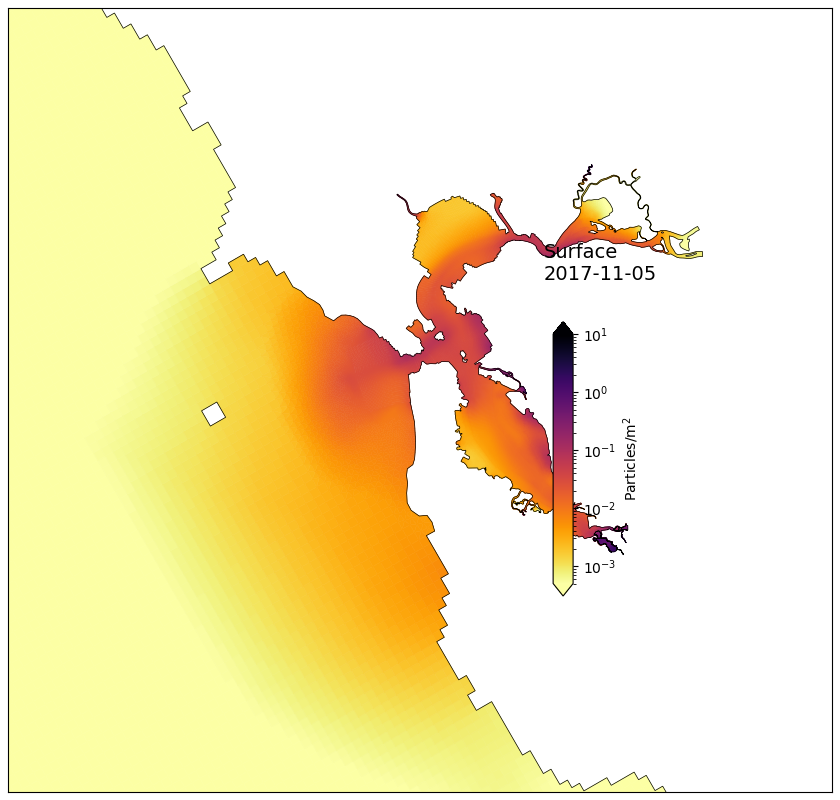

In [55]:
bf=BayFig(ds_grid,labels=["Surface",date])
#bf.fig.savefig(os.path.join(fig_dir,f"surface-{date}.png"))

In [ ]:
# NEXT: snapshot of near bed concentration
# Can I do an annual average of bed hits?
beach_rate,depo_rate,decay_rate=[0.03704715, 0.03691037, 0.02668093]